# Correlations between indices and ground truth



## 1. Load packages

In [7]:
# -*- coding: utf-8 -*-
"""
Updated 20 January 2025

"""

from IPython import get_ipython
print(__doc__)

# Clear all the variables
get_ipython().run_line_magic('reset', '-sf')

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path 
import matplotlib.pyplot as plt
import pandas as pd 
pd.options.display.float_format = "{:,.2f}".format # display numbers with 2 decimals
import os
import sys
import numpy as np
from scipy.stats import spearmanr
import seaborn as sns
from tqdm import tqdm
from maad import util

sys.path.append(str(Path('../src')))
from stat_func import bootstrap_corr, permutation_corr

# Close all the figures (like in Matlab)
plt.close("all")

# Import configuration file
import config as cfg


Updated 20 January 2025




## 2. Notebook init and options setting

* Select the annotation file
* Select the dataset to analyze

In [8]:
"""****************************************************************************
                                   options          
****************************************************************************"""

# Set the options
SAVE = True
PROCESS = False
DISPLAY = True
VERBOSE = False

# Load the configuration file
# CONFIG = cfg.load_config('config_publication.yaml')
CONFIG = cfg.load_config('config_publication_local.yaml')

# Set the global variables
GT = CONFIG['ground_truth']
CORR_METHOD = CONFIG['correlation_method']
N_BOOT = CONFIG['n_bootstrap']
R_THRESHOLD = 0.3 # threshold to select the correlation coefficients to display

# initialize the list of indices, annotations and sites
INDICES_ALL = []
ANNOTATIONS_ALL = []
SITES_ALL = []

# loop over the datasets to get the filenames of the indices and annotations and the selected sites corresponding to each dataset
for DATASET in CONFIG['datasets']:

       """***************************************************************************
                     Prepare the configuration for the dataset
       ***************************************************************************"""

       filename_indices = 'indices_'+DATASET['name']+'_BW'+str(DATASET['flim_min'])+'Hz_'+str(DATASET['flim_max'])+'Hz_'+str(CONFIG['seed_level'])+'db'+'.csv'

       INDICES_ALL     += [(filename_indices, CONFIG['save_dir'])]
       ANNOTATIONS_ALL += [(CONFIG['annotations_filename'], os.path.dirname(DATASET['path']))] 
       SITES_ALL       += DATASET['sites']

       # display the dataset name
       print(f'Dataset {DATASET["name"]} is being preparing...')       
       # display the number of sites
       print(f'The dataset {DATASET["name"]} contains {len(DATASET["sites"])} sites \n')

"""****************************************************************************
                            options for display     
****************************************************************************"""

PALETTE_NAME = "Set2" # Set1 Set2 Set3 husl colorblind tab20
NUM_COLORS = 8

# set a dictionnary with the color for each habitat
HABITAT_COLOR = {
       'Arable land': sns.color_palette(PALETTE_NAME, NUM_COLORS)[0],
       'Forest - Subtropical-tropical moist lowland': sns.color_palette(PALETTE_NAME, NUM_COLORS)[1],
       'Forest - Subtropical-tropical moist montane': sns.color_palette(PALETTE_NAME, NUM_COLORS)[2],
       'Plantations': sns.color_palette(PALETTE_NAME, NUM_COLORS)[3],
       'Forest - Temperate': sns.color_palette(PALETTE_NAME, NUM_COLORS)[4],
       'Shrubland - Subtropical-tropical high altitude': sns.color_palette(PALETTE_NAME, NUM_COLORS)[5],
       'Shrubland - Temperate': sns.color_palette(PALETTE_NAME, NUM_COLORS)[6],
       }

# Get the default palette
RED     = sns.color_palette('Set1')[0]
BLUE    = sns.color_palette('Set1')[1]
GREEN   = sns.color_palette('Set1')[2]


Dataset sapsucker_woods is being preparing...
The dataset sapsucker_woods contains 1 sites 

Dataset bialowieza is being preparing...
The dataset bialowieza contains 15 sites 

Dataset hawai is being preparing...
The dataset hawai contains 2 sites 

Dataset coffee_farms is being preparing...
The dataset coffee_farms contains 2 sites 

Dataset usa_sierra_nevada_forest is being preparing...
The dataset usa_sierra_nevada_forest contains 33 sites 

Dataset uk_sussex_countryside is being preparing...
The dataset uk_sussex_countryside contains 45 sites 

Dataset ecuador is being preparing...
The dataset ecuador contains 45 sites 

Dataset risoux is being preparing...
The dataset risoux contains 1 sites 

Dataset peru is being preparing...
The dataset peru contains 7 sites 



## 3. Preparation of the dataframe df

* Open and read dataframes with indices (variables) and with labels (ground truth)
* Clean and merge both dataframes

### 3.1 Clean, merge and save the dataframe with all the data

* Indices where previously calculated with scikit-maad package (V1.5.1) on Python.
* Manual annotations are coming from different datasets that belong to very different projects. They were formated to be readable in the same way.

> Indices and manual annotations are merged into a single dataframe. Some variables are renamed while others are dropped because we do not want to analyse them. The final dataframe is saved for further analyses, for instance in R.

In [10]:
"""****************************************************************************
                                Dataframe creation  
****************************************************************************"""
# LOAD CSV
df_indices = pd.DataFrame()
for indices_csv, indices_dir in INDICES_ALL :
    df_indices = pd.concat([df_indices, pd.read_csv(os.path.join(indices_dir,indices_csv), sep=',')], axis=0)

df_label = pd.DataFrame()
for annotations_csv, annotations_dir in ANNOTATIONS_ALL :
    # add a column dataset containing the dataset name (last  part of the path in annotations_dir)
    df_temp = pd.read_csv(os.path.join(annotations_dir,annotations_csv), sep=',')
    df_temp['dataset'] = annotations_dir.split('/')[-1]
    df_label = pd.concat([df_label, df_temp], axis=0)
    
# select a site
df_label = df_label[df_label['site'].isin(SITES_ALL)]

# # drop clipping rows
# if CONFIG['remove_clipping_audio'] :
#     df_indices = df_indices[df_indices['clipping'] == 0]

# add a column Filename such as in df_label
df_indices['filename'] = df_indices['file'].apply(lambda x: os.path.basename(x).split('.')[0])
df_indices.drop(['Date','file','clipping'], axis='columns', inplace=True)

# set index
df_indices.set_index('filename', inplace = True)
df_label.set_index('filename', inplace = True)

# keep only richness ('species_richness')
df_label = df_label[[ 'date', 'site', 'device_id', 'biome', 'dataset', 'species_richness']]

# Rename the column biome into habitat
df_label = df_label.rename(columns={'biome':'habitat'})

# HACK
df_label['species_richness'] = df_label['species_richness'].astype('float')

# Remove  ENRf which is the same as LEQf
try :
    df_indices.drop(['ENRf', 'audio_duration'], axis='columns', inplace=True)
except :
    pass

# Create H indice, a composite of Ht and Hf
df_indices['H'] = df_indices['Ht'] * df_indices['Hf']
# Rename some indices
df_indices = df_indices.rename(columns={'NBPEAKS':'NP'})
df_indices = df_indices.rename(columns={'BI':'BIO'})
df_indices = df_indices.rename(columns={'MED':'M'})

# transform the values into float
df_indices = df_indices.select_dtypes(include=['number']).astype('float')

# Create a new df by merging df_indices and df_label
df = pd.merge(df_indices, df_label, on='filename', how='inner')

if CONFIG['remove_clipping_audio'] :
    print('The number of files after removing clipped audio')

print('The total number of files {}'.format(len(df)))

# display the number of files per dataset
for dataset in CONFIG['datasets'] :
    print(f'The number of files for the dataset {dataset["name"]} is {len(df[df["site"].isin(dataset["sites"])])}')

# display the number of files per habitat and the number of sites per habitat
print('\n')
for habitat in df['habitat'].unique() :
    print(f'The number of files for the habitat {habitat} is {len(df[df["habitat"] == habitat])}')
    print(f'The number of sites for the habitat {habitat} is {len(df[df["habitat"] == habitat]["site"].unique())} \n')


# # average species richness and nROI per site keeping site, habitat and recorder_type
# data = df.groupby(['site', 'habitat', 'device_id', 'dataset']).agg({
#     'species_richness': 'mean',
#     'nROI': 'mean',
# }).reset_index()

# save the dataframe
if SAVE :
    df.to_csv(path_or_buf=os.path.join(CONFIG['save_dir'], 'data_statistical_model.csv'), sep=',', mode='w', header=True, index=True)


The number of files after removing clipped audio
The total number of files 4484
The number of files for the dataset sapsucker_woods is 544
The number of files for the dataset bialowieza is 540
The number of files for the dataset hawai is 357
The number of files for the dataset coffee_farms is 112
The number of files for the dataset usa_sierra_nevada_forest is 132
The number of files for the dataset uk_sussex_countryside is 1982
The number of files for the dataset ecuador is 675
The number of files for the dataset risoux is 58
The number of files for the dataset peru is 84


The number of files for the habitat Forest - Temperate is 1949
The number of sites for the habitat Forest - Temperate is 65 

The number of files for the habitat Shrubland - Subtropical-tropical high altitude is 227
The number of sites for the habitat Shrubland - Subtropical-tropical high altitude is 1 

The number of files for the habitat Forest - Subtropical-tropical moist montane is 355
The number of sites for th

=== COMPARISON OF MODELS ===

1. Standard GLM with Negative Binomial Distribution
--------------------------------------------------
                 Generalized Linear Model Regression Results                  
Dep. Variable:       species_richness   No. Observations:                  151
Model:                            GLM   Df Residuals:                      136
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -356.25
Date:                Fri, 19 Sep 2025   Deviance:                       12.219
Time:                        23:15:37   Pearson chi2:                     10.3
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1474
Covariance Type:            nonrobust                                         
                                                                coef    std e

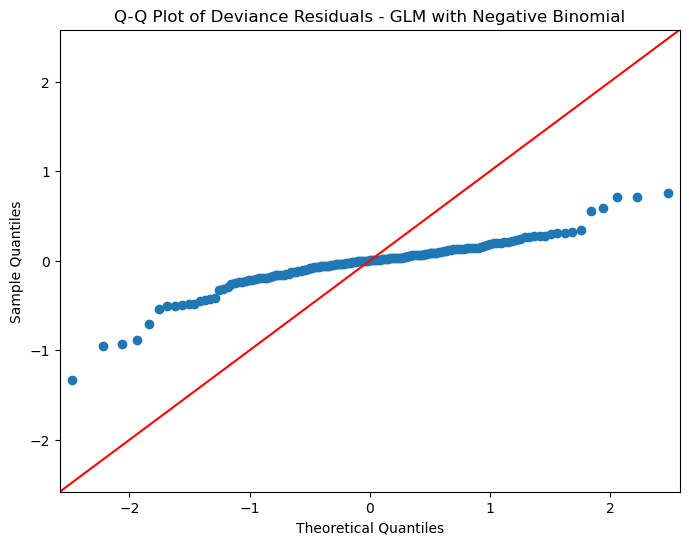

=== COMPARISON OF MODELS ===

1. Standard GLM with Negative Binomial Distribution
--------------------------------------------------
                 Generalized Linear Model Regression Results                  
Dep. Variable:       species_richness   No. Observations:                  151
Model:                            GLM   Df Residuals:                      136
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -356.25
Date:                Fri, 19 Sep 2025   Deviance:                       12.219
Time:                        23:15:37   Pearson chi2:                     10.3
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1474
Covariance Type:            nonrobust                                         
                                                                coef    std e

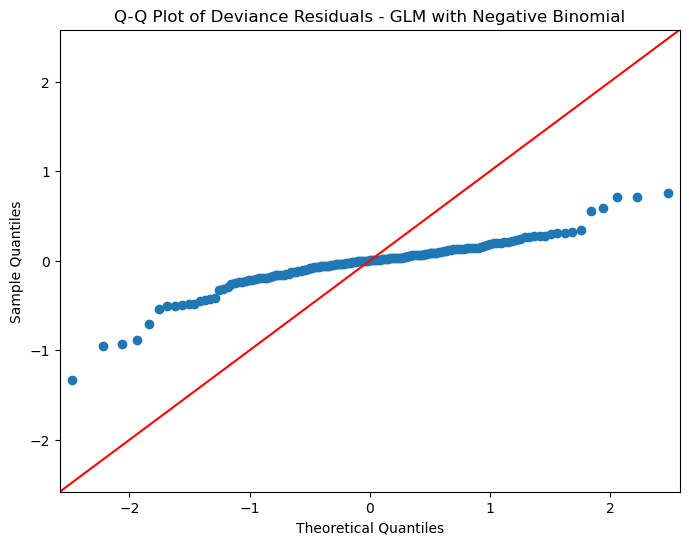

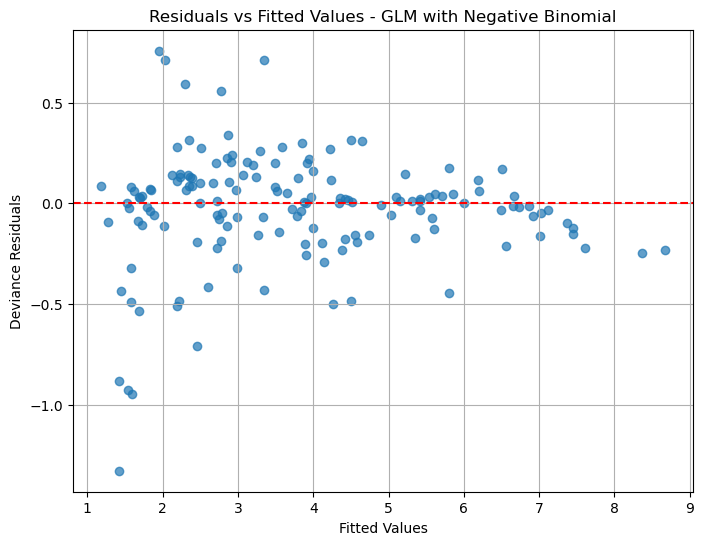

=== COMPARISON OF MODELS ===

1. Standard GLM with Negative Binomial Distribution
--------------------------------------------------
                 Generalized Linear Model Regression Results                  
Dep. Variable:       species_richness   No. Observations:                  151
Model:                            GLM   Df Residuals:                      136
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -356.25
Date:                Fri, 19 Sep 2025   Deviance:                       12.219
Time:                        23:15:37   Pearson chi2:                     10.3
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1474
Covariance Type:            nonrobust                                         
                                                                coef    std e

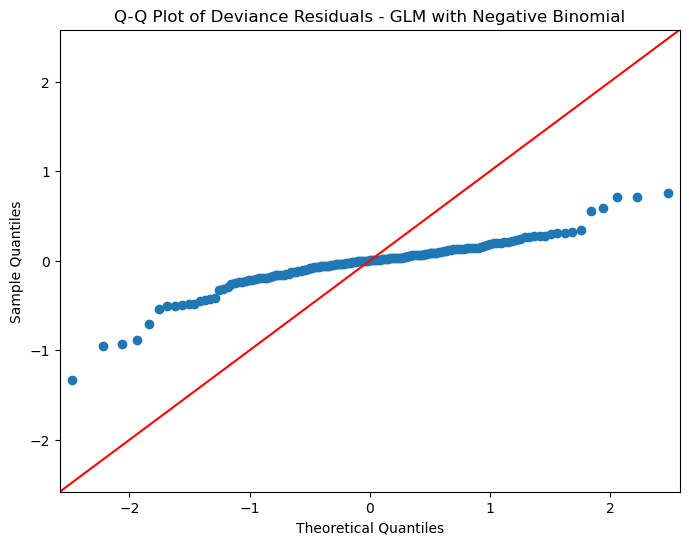

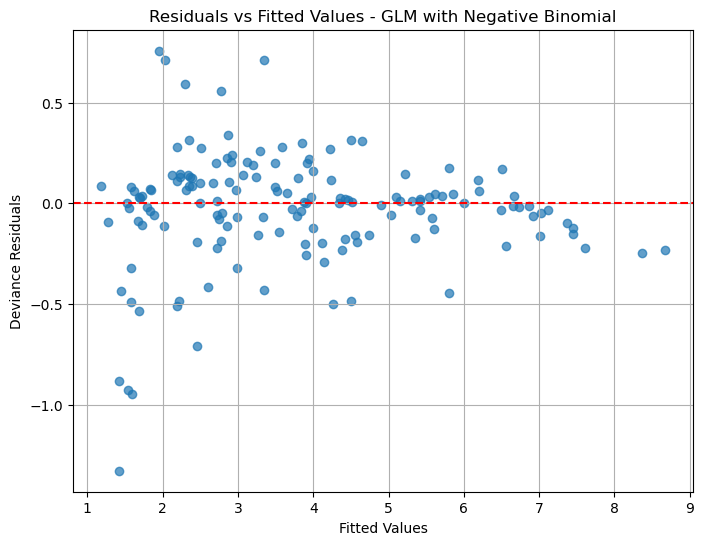

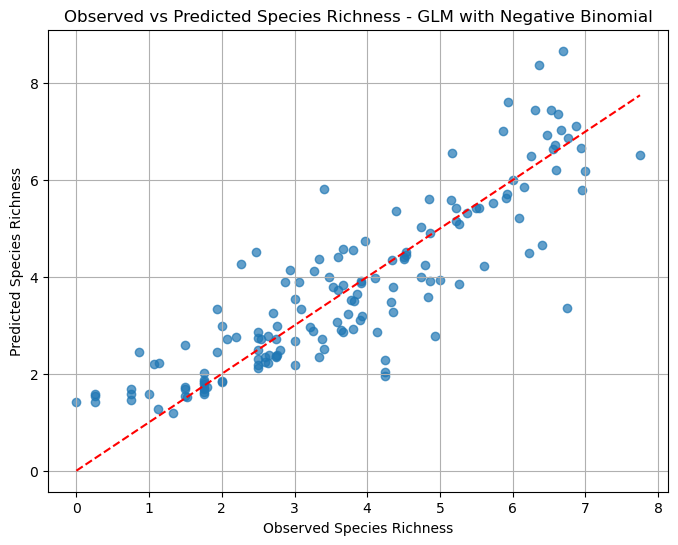

=== COMPARISON OF MODELS ===

1. Standard GLM with Negative Binomial Distribution
--------------------------------------------------
                 Generalized Linear Model Regression Results                  
Dep. Variable:       species_richness   No. Observations:                  151
Model:                            GLM   Df Residuals:                      136
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -356.25
Date:                Fri, 19 Sep 2025   Deviance:                       12.219
Time:                        23:15:37   Pearson chi2:                     10.3
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1474
Covariance Type:            nonrobust                                         
                                                                coef    std e

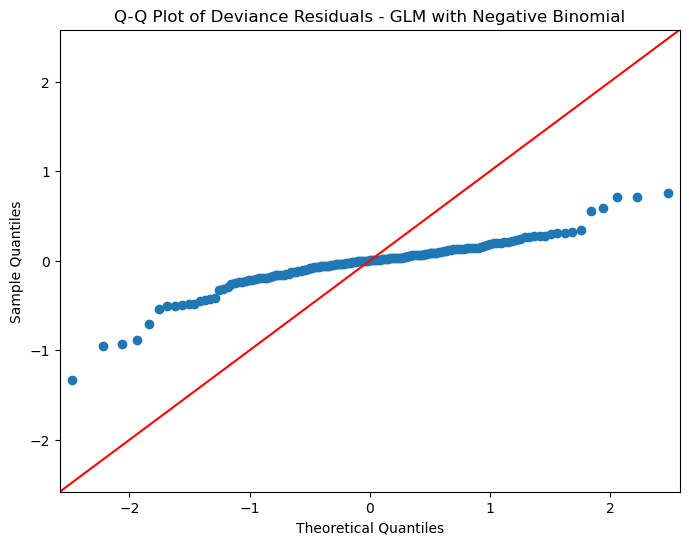

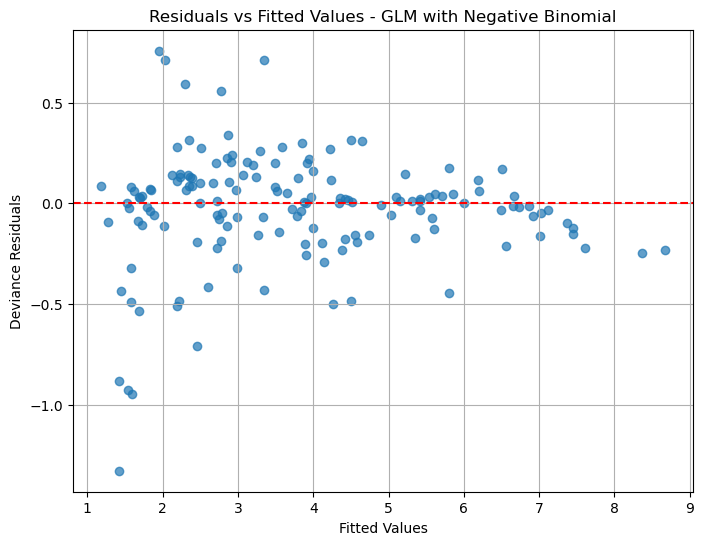

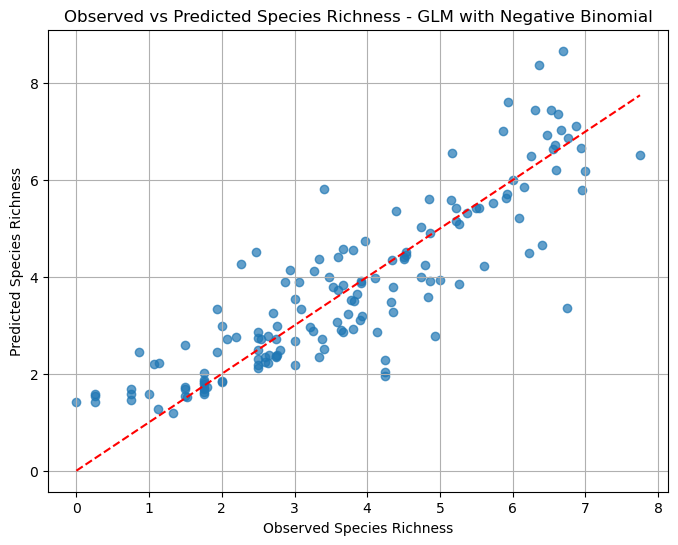

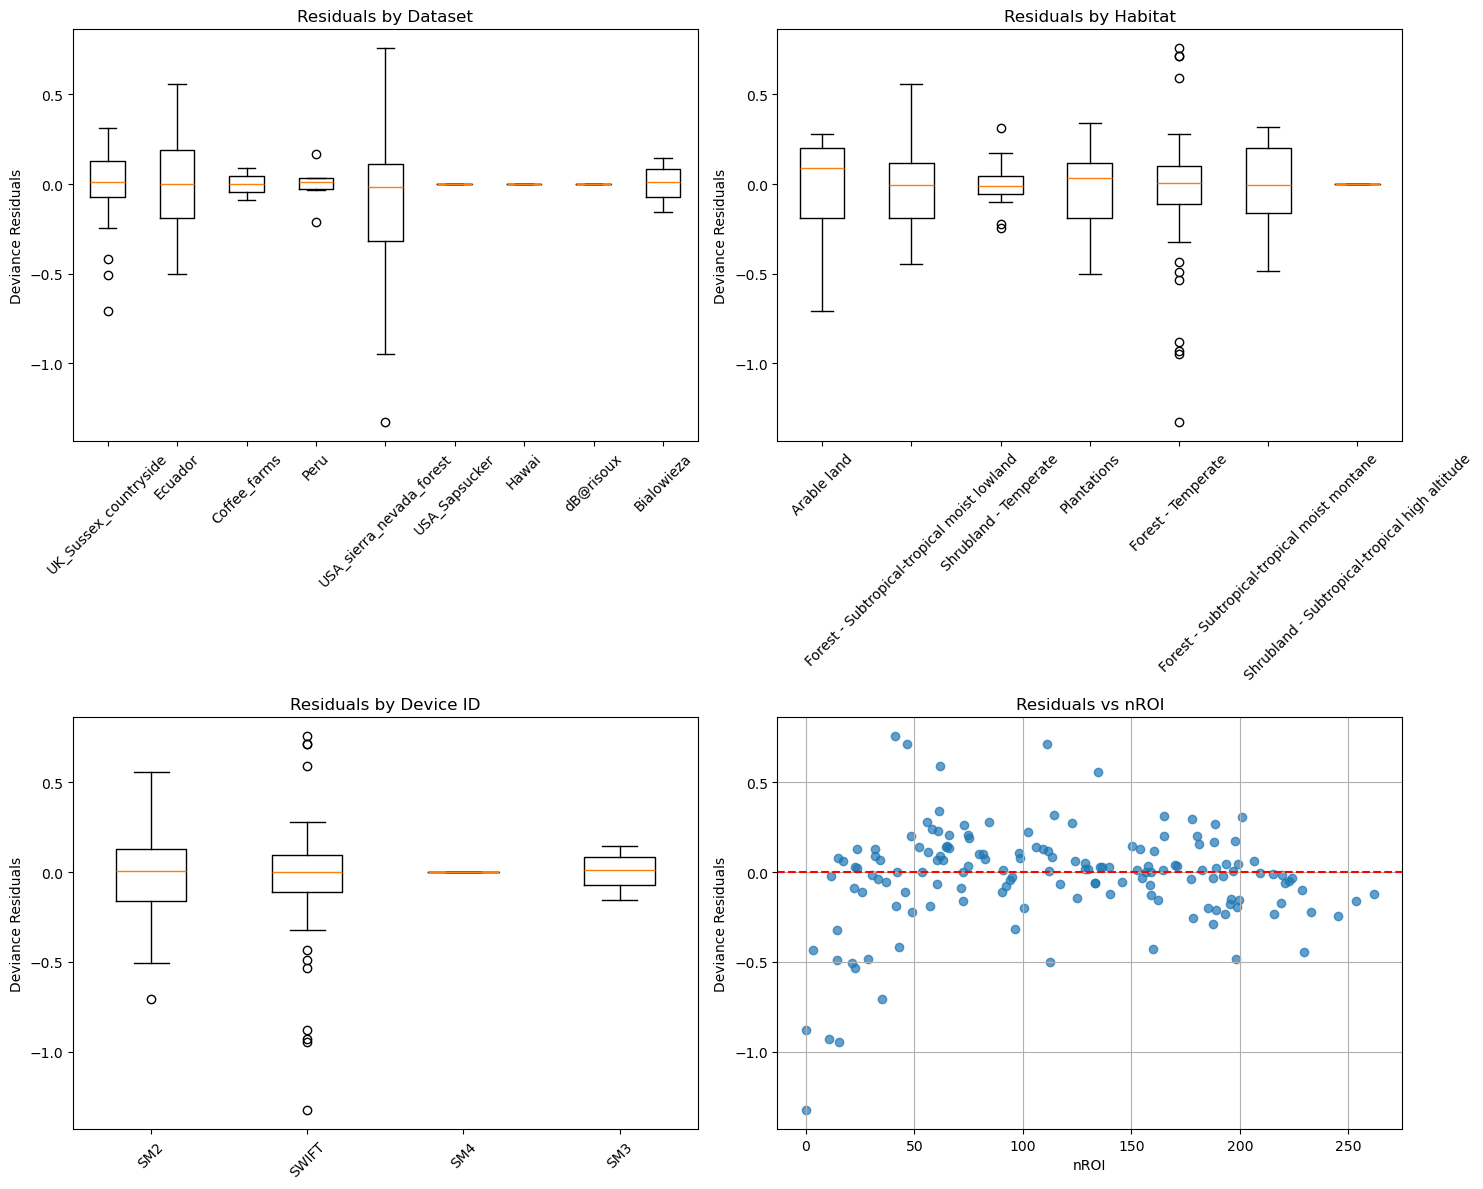


RECOMMENDATIONS:
1. Consider using R with lme4 package for full GLMM with Negative Binomial
2. The residual plots by groups show if random effects are needed
3. If residuals show clear patterns by groups, random effects are justified
4. Current GLM assumes independence - mixed models account for clustering


In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.families import NegativeBinomial
from scipy.optimize import minimize

# Convert categorical variables to category dtype (already done, but safe to repeat)
data['device_id'] = data['device_id'].astype('category')
data['site'] = data['site'].astype('category')
data['habitat'] = data['habitat'].astype('category')
data['dataset'] = data['dataset'].astype('category')

print("=== COMPARISON OF MODELS ===\n")

# ===============================
# MODEL 1: Standard GLM (Original)
# ===============================
print("1. Standard GLM with Negative Binomial Distribution")
print("-" * 50)

# Define the negative binomial regression formula
formula_glm = "species_richness ~ nROI + device_id + habitat + dataset"

# Fit the negative binomial model (no random effects)
model_nb = smf.glm(formula_glm, data=data, family=sm.families.NegativeBinomial())
results_nb = model_nb.fit()
print(results_nb.summary())

# Calculate AIC and BIC for model comparison
aic_glm = results_nb.aic
bic_glm = results_nb.bic
print(f"\nGLM Model Fit Statistics:")
print(f"AIC: {aic_glm:.2f}")
print(f"BIC: {bic_glm:.2f}")

# which coefficients are significant at p < 0.05
significant_coefficients_glm = results_nb.pvalues[results_nb.pvalues < 0.05]
print(f"\nSignificant coefficients (p < 0.05): {len(significant_coefficients_glm)}")
print(significant_coefficients_glm)

print("\n" + "="*70 + "\n")

# ===============================
# MODEL 2: Mixed Effects Model (GLMM)
# ===============================
print("2. Generalized Linear Mixed Model (GLMM)")
print("-" * 50)

try:
    # Try using statsmodels MixedLM with Poisson family as approximation
    from statsmodels.genmod.families import Poisson
    
    # For GLMM, we'll use a simpler approach with random intercepts
    # Note: statsmodels has limited support for non-Gaussian mixed models
    
    # Formula with random effects (using groups parameter)
    formula_mixed = "species_richness ~ nROI"
    
    # Fit mixed model with random intercepts for device_id, habitat, and dataset
    # We'll use Poisson as approximation since NB mixed models are complex in statsmodels
    model_mixed = smf.mixedlm(formula_mixed, data, groups=data['dataset'], 
                             re_formula="1", family=Poisson())
    results_mixed = model_mixed.fit()
    print(results_mixed.summary())
    
    # Calculate AIC for model comparison
    aic_mixed = results_mixed.aic
    bic_mixed = results_mixed.bic
    print(f"\nMixed Model Fit Statistics:")
    print(f"AIC: {aic_mixed:.2f}")
    print(f"BIC: {bic_mixed:.2f}")
    
    print(f"\nModel Comparison:")
    print(f"GLM AIC: {aic_glm:.2f} vs Mixed Model AIC: {aic_mixed:.2f}")
    print(f"GLM BIC: {bic_glm:.2f} vs Mixed Model BIC: {bic_mixed:.2f}")
    
    if aic_mixed < aic_glm:
        print("✓ Mixed model has better fit (lower AIC)")
    else:
        print("✓ GLM has better fit (lower AIC)")

except Exception as e:
    print(f"Note: Full GLMM with Negative Binomial not directly supported in statsmodels")
    print(f"Error: {e}")
    print("\nAlternative approaches:")
    print("1. Use R with lme4 package for full GLMM support")
    print("2. Use Python packages like pymer4 or statsmodels approximations")

print("\n" + "="*70 + "\n")

# ===============================
# MODEL 3: Hierarchical approach with nested random effects
# ===============================
print("3. Hierarchical Mixed Model (Alternative)")
print("-" * 50)

try:
    # Create a hierarchical grouping variable
    data['hierarchy'] = data['dataset'].astype(str) + "_" + data['habitat'].astype(str)
    
    # Fit with nested random effects
    formula_hierarchical = "species_richness ~ nROI"
    model_hierarchical = smf.mixedlm(formula_hierarchical, data, 
                                   groups=data['hierarchy'], 
                                   re_formula="1")
    results_hierarchical = model_hierarchical.fit()
    print(results_hierarchical.summary())
    
    aic_hier = results_hierarchical.aic
    bic_hier = results_hierarchical.bic
    print(f"\nHierarchical Model Fit Statistics:")
    print(f"AIC: {aic_hier:.2f}")
    print(f"BIC: {bic_hier:.2f}")
    
except Exception as e:
    print(f"Hierarchical model error: {e}")

print("\n" + "="*70 + "\n")

# ===============================
# DIAGNOSTIC PLOTS FOR BEST MODEL
# ===============================
print("4. Model Diagnostics")
print("-" * 50)

# Use the original GLM for diagnostic plots (most complete implementation)
best_model = results_nb
best_model_name = "GLM with Negative Binomial"

print(f"Generating diagnostic plots for: {best_model_name}")

# Q-Q Plot
fig, ax = plt.subplots(figsize=(8, 6))
sm.qqplot(best_model.resid_deviance, line='45', ax=ax)
ax.set_title(f'Q-Q Plot of Deviance Residuals - {best_model_name}')
ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Sample Quantiles')  
plt.show()

# Residuals vs Fitted
plt.figure(figsize=(8, 6))
plt.scatter(best_model.fittedvalues, best_model.resid_deviance, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Deviance Residuals')
plt.title(f'Residuals vs Fitted Values - {best_model_name}')
plt.grid()
plt.show()

# Observed vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(data['species_richness'], best_model.fittedvalues, alpha=0.7)
plt.plot([data['species_richness'].min(), data['species_richness'].max()], 
         [data['species_richness'].min(), data['species_richness'].max()], 
         color='red', linestyle='--')
plt.xlabel('Observed Species Richness')
plt.ylabel('Predicted Species Richness')
plt.title(f'Observed vs Predicted Species Richness - {best_model_name}')
plt.grid()
plt.show()

# Additional diagnostic: Residuals by groups
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Residuals by dataset
axes[0,0].boxplot([best_model.resid_deviance[data['dataset'] == dataset] 
                   for dataset in data['dataset'].unique()], 
                  labels=data['dataset'].unique())
axes[0,0].set_title('Residuals by Dataset')
axes[0,0].set_ylabel('Deviance Residuals')
axes[0,0].tick_params(axis='x', rotation=45)

# Residuals by habitat
axes[0,1].boxplot([best_model.resid_deviance[data['habitat'] == habitat] 
                   for habitat in data['habitat'].unique()], 
                  labels=data['habitat'].unique())
axes[0,1].set_title('Residuals by Habitat')
axes[0,1].set_ylabel('Deviance Residuals')
axes[0,1].tick_params(axis='x', rotation=45)

# Residuals by device_id
axes[1,0].boxplot([best_model.resid_deviance[data['device_id'] == device] 
                   for device in data['device_id'].unique()], 
                  labels=data['device_id'].unique())
axes[1,0].set_title('Residuals by Device ID')
axes[1,0].set_ylabel('Deviance Residuals')
axes[1,0].tick_params(axis='x', rotation=45)

# Residuals vs nROI
axes[1,1].scatter(data['nROI'], best_model.resid_deviance, alpha=0.7)
axes[1,1].axhline(0, color='red', linestyle='--')
axes[1,1].set_xlabel('nROI')
axes[1,1].set_ylabel('Deviance Residuals')
axes[1,1].set_title('Residuals vs nROI')
axes[1,1].grid()

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("RECOMMENDATIONS:")
print("="*70)
print("1. Consider using R with lme4 package for full GLMM with Negative Binomial")
print("2. The residual plots by groups show if random effects are needed")
print("3. If residuals show clear patterns by groups, random effects are justified")
print("4. Current GLM assumes independence - mixed models account for clustering")